In [ ]:
from controlled_config import ControlledConfig
from rir_interface import taslp_RIR_Interface
from array_setup import array_setup_10cm_2mic
from locata_utils import cart2sph


import numpy as np
import matplotlib.pyplot as plt

In [ ]:
rir_interface = taslp_RIR_Interface()

snr = -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0
scenario = "source_moving"
test_config = ControlledConfig(array_setup=array_setup_10cm_2mic, snr=snr, t60=t60,
                                    src_mic_dist = src_mic_dist, noi_mic_dist = noi_mic_dist, 
                                    nb_points=16, same_plane=True)

for idx in range(0, 1):									
    retry_flag = True
    retry_count = 0
    while(retry_flag):
        try:
            static_config_dict = test_config._create_acoustic_scene_config("Static")
            circular_motion_config_dict = test_config._create_acoustic_scene_config("CircularMotion", scenario)
            retry_flag = False
        except AssertionError:
            retry_flag = True
            retry_count += 1	

config_dict = static_config_dict #circular_motion_config_dict
room_sz = config_dict['room_sz']
array_pos = config_dict['array_pos']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']		

### Mapping config pos to keys of rir (Interface)

src_azimuth = np.degrees(cart2sph(traj_pts - array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

source_rirs, dp_source_rirs = rir_interface.get_rirs(t60=T60, idx_list=list(src_azimuth_keys))

noi_azimuth = np.degrees(cart2sph(noise_pos - array_pos)[:,2])
noi_azimuth_keys = np.round(np.where(noi_azimuth<0, 360+noi_azimuth, noi_azimuth)).astype('int32')	
noise_rirs, _ = rir_interface.get_rirs(t60=T60, idx_list=list(noi_azimuth_keys))


In [ ]:
src_azimuth, source_rirs.shape


In [ ]:
import matplotlib.pyplot as plt

plt.plot(source_rirs[0,0,:300],'b')
plt.plot(source_rirs[0,1,:300],'r')

In [ ]:
source_rirs_86, dp_source_rirs_86 = rir_interface.get_rirs(t60=T60, idx_list=[86])

In [ ]:
plt.plot(source_rirs_86[0,0,:300],'b')
plt.plot(source_rirs_86[0,1,:300],'r')

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

t60 = 0.2
files_list = f'/fs/scratch/PAS0774/Shanmukh/Databases/RIRs/taslp_roomdata_360_resolution_1degree/HABET_SpacedOmni_8x8x3_height1.5_dist1_roomT60_{t60}.mat'
rir = sio.loadmat(files_list)
_h = rir['trainingroom']

In [ ]:
h = _h[0,86][0]
h.shape

In [ ]:
plt.plot(h[:100,0])
plt.plot(h[:100,1])

In [ ]:

x = np.array(_h.tolist()).squeeze()
x_1 = np.transpose(x,(0,2,1))
x = np.transpose(x,(0,2,1))
x = x.astype('float32')

In [ ]:
x.shape,

In [ ]:
np.sum(x[86,:,0]**2), np.sum(x[86,:,1]**2), np.sum(x_1[86,0,:]**2), np.sum(x_1[86,1,:]**2)

In [ ]:
plt.plot(x[86,:,0])
plt.plot(x[86,:,1])

In [ ]:
q1 = x[86,:,:]

In [ ]:
q1.shape

In [ ]:
import torch
q1 = torch.from_numpy(q1)
flip_q1 = torch.flip(q1, [1])

In [ ]:
flip_q1.shape

In [ ]:
plt.plot(q1[0],'b')
plt.plot(flip_q1[0],'r')

In [ ]:
import torchaudio
sig,fs = torchaudio.load('../signals/tgt_0.wav')

In [ ]:
sig.shape

In [ ]:
q1 = x[86,:,:]
speech_ = torch.nn.functional.pad(sig[[0],:], (flip_q1.shape[1]-1, flip_q1.shape[1]-1))
augmented = torch.nn.functional.conv1d(speech_.unsqueeze(dim=1), flip_q1.unsqueeze(dim=1))


In [ ]:
flip_q1.shape, speech_.shape

In [ ]:
augmented.shape

In [ ]:
speech_.shape

In [ ]:
plt.plot(sig[0])
plt.plot(speech_[0])

In [ ]:
augmented.shape

In [ ]:
augmented[0]

In [ ]:
ts = np.arange(16) * 64000 / 16000 / 16

In [ ]:
blk_len = int(64000/16)


In [ ]:
blk_len

In [ ]:
seg_sig = torch.nn.functional.unfold(sig[[0],:].unsqueeze(dim=1).unsqueeze(dim=1), kernel_size=(1, blk_len), padding=(0,0), stride=(1, blk_len))

In [ ]:
seg_sig.shape

In [ ]:
seg_sig = torch.permute(seg_sig,[0,2,1])

In [ ]:
from scipy.signal import fftconvolve

In [ ]:
speech_.shape, q1.shape

In [ ]:
sph_rev = fftconvolve(speech_.numpy(), q1[[0],:], mode='valid')
sph_rev_2 = fftconvolve(sig[[0],:].numpy(), q1[[0],:], mode='full')

In [ ]:
sph_rev_3 = fftconvolve(sig[[0],:].numpy(), q1, mode='full')


In [ ]:
plt.plot(sph_rev_3[0,10000:12000])
plt.plot(sph_rev_3[1,10000:12000])

In [ ]:
conv_out = augmented[0,[0],:].numpy()

In [ ]:
import time

sig,fs = torchaudio.load('../signals/tgt_0.wav')
q1 = x[86,:,:]
q1 = torch.from_numpy(q1)
flip_q1 = torch.flip(q1, [1])

start = time.time()

speech_ = torch.nn.functional.pad(sig[[0],:], (flip_q1.shape[1]-1, flip_q1.shape[1]-1))
augmented = torch.nn.functional.conv1d(speech_.unsqueeze(dim=1), flip_q1.unsqueeze(dim=1))

end = time.time() - start

print(f"conv: {end}\n")

start = time.time()

sph_rev_2 = fftconvolve(sig[[0],:].numpy(), q1, mode='full')


fft_end = time.time() - start

print(f"fftconv: {fft_end}\n")


In [ ]:
conv_out.dtype

In [ ]:
sph_rev[0,12000], sph_rev_2[0,12000], conv_out[0,12000]

In [ ]:
plt.plot(conv_out[0,:]-sph_rev_2[0,:])

In [ ]:
plt.plot(sph_rev[0,:]-sph_rev_2[0,:])


In [ ]:
sph_rev.shape, sph_rev.dtype, sph_rev_2.shape, sph_rev_2.dtype 

In [ ]:
import torchaudio
mine_sig,fs = torchaudio.load('mine.wav')
gpuRIR_sig,fs = torchaudio.load('gpuRIR.wav')

In [ ]:
plt.plot(mine_sig[0])
plt.plot(gpuRIR_sig[0])

In [ ]:
(gpuRIR_sig==mine_sig)[0].shape

In [ ]:
diff = (gpuRIR_sig-mine_sig)
plt.plot(diff[0,:20000])

In [ ]:
torch.where(diff[0] !=0)

In [ ]:
diff[0,45800]

In [ ]:
gpuRIR_sig.shape

In [ ]:
diff = (gpuRIR_sig==mine_sig)


In [ ]:
(torch.where(diff[0] == False))[0].shape

In [ ]:
torch.where(diff[0] == False)

In [ ]:
rir_interface = taslp_RIR_Interface()
rirs, dp_rirs = rir_interface.get_rirs(t60=0.0, idx_list=[4])

plt.plot(rirs[0,0,:], 'b')
plt.plot(dp_rirs[0,0,:], 'r')

In [ ]:
np.where(rirs[0,0,:]==dp_rirs[0,0,:])

In [ ]:
rirs[0,0,89:]

In [ ]:
import numpy as np
t60_list = [round(i,1) for i in np.arange(0, 1.1, 0.1) if i != 0.1]

In [ ]:
f_reverb = open('../dataset_file_circular_motion_snr_-5_t60_0.2_reverb.txt', 'w')
with open('../dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        t60 = np.random.choice(t60_list)
        app_t60_str = f',{t60}\n'
        _line = line.strip()+app_t60_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [ ]:
type(line)

In [ ]:
with open('../Logs/inputs/reverb/input-1.txt', 'r') as f:
    lines = [line for line in f.readlines()]

#key value 
for line in lines:
    lst = line.strip().split()
    if lst[0]=="T60":
        T60 = float(lst[1])
    elif lst[0]=="dataset_dtype":
        dataset_dtype = lst[1]

In [ ]:
T60, type(T60)

In [ ]:
dataset_dtype, type(dataset_dtype)

In [ ]:
f_reverb = open('../val_dataset_file_circular_motion_snr_-5_t60_0.2_noisy.txt', 'w')
with open('../val_dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        snr = np.random.uniform(-5.0,5.01)
        app_snr_str = f',{snr}\n'
        _line = line.strip()+app_snr_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [ ]:
import numpy as np


In [ ]:
f_reverb = open('../dataset_file_circular_motion_snr_-5_t60_0.2_noisy_reverb.txt', 'w')
with open('../dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        snr = np.random.uniform(-5.0,5.01)
        t60 = np.random.choice(t60_list)
        app_snr_str = f',{snr},{t60}\n'
        _line = line.strip()+app_snr_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [ ]:
snr_list = [-5, 0, 5, 10, 20]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]

idx=1
for snr in snr_list:
    for t60 in t60_list:
        name = f'../Logs/inputs/noisy_reverb/input-{idx}.txt'
        f = open(name, 'w')
        f.write(f'SNR {snr}\n')
        f.write(f'T60 {t60}\n')
        f.close()
        idx +=1


In [ ]:
#import torch
#torch.save(exp_dict, "noisy_reverb_results.pt")


In [ ]:
lst = pesq_line.split()

In [ ]:
def get_test_config_details(lst):
    ckpt_name_list = lst[1].split('/')
    train, mic_idx = ckpt_name_list[-3], ckpt_name_list[-1][-2]

    exp_name_list = lst[-1].split('_')
    #idx = 4 if exp_name_list[-1][0]=='-' else 3
    snr, t60, test = exp_name_list[-1][:-3], exp_name_list[-3], exp_name_list[-5]

    return mic_idx, train, test, t60, snr

In [ ]:
mic_idx=1
t60 = 0.2
train = 'stationary'
test = 'stationary'
snr = 5.0

# for snr in snr_list:
for t60 in t60_list:
    for test in scenarios:
        key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_t60_{t60}_snr_{snr}'
        print(exp_dict[key_str])

In [ ]:
import torch
exp_dict = torch.load('../Logs/noisy_reverb/noisy_reverb_results.pt')

mic_idx=1
train = 'stationary'
snr = 20.0
# for snr in snr_list:
for t60 in t60_list:
    for test in scenarios:
        key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_t60_{t60}_snr_{snr}'
        print(f'{t60}, {test}, {exp_dict[key_str]}')

In [ ]:
# real to complex
import torch
a = torch.rand(2,2,5,6)

c = torch.complex(a[:,0,:,:], a[:,1,:,:])


In [ ]:
c.shape


In [ ]:
a

In [ ]:
c


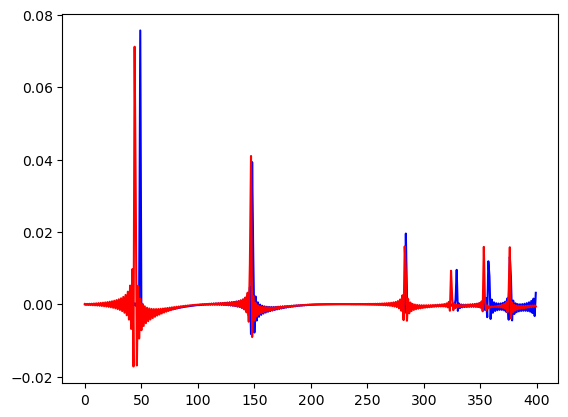

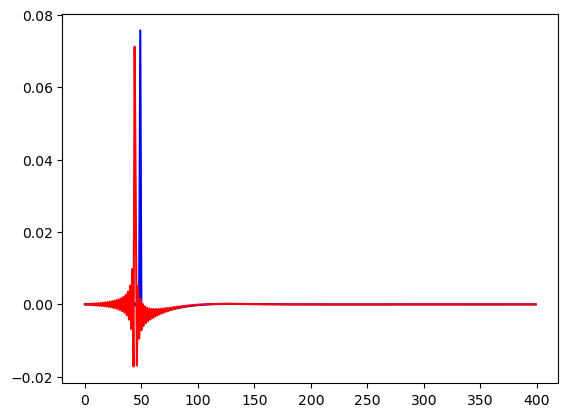

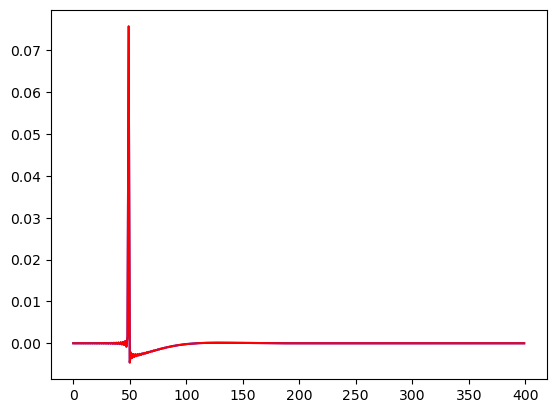

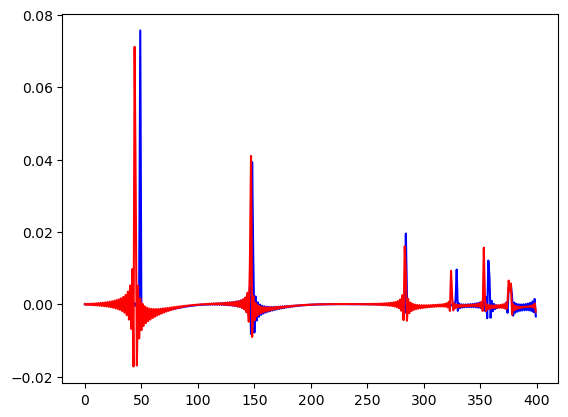

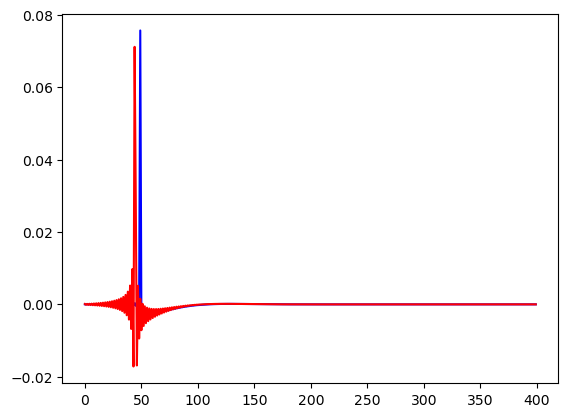

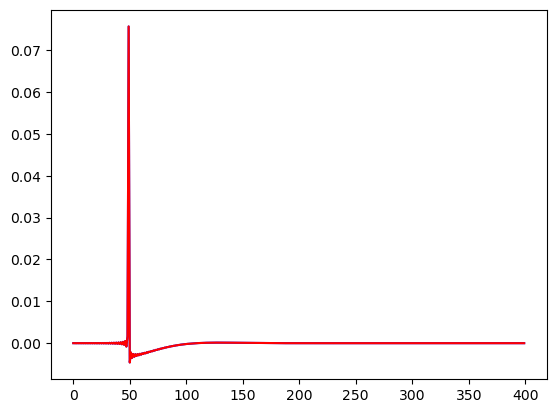

In [1]:
import matplotlib.pyplot as plt
from rir_interface import taslp_real_RIR_Interface, taslp_RIR_Interface
import numpy as np
array_type, num_mics, intermic_dist,  room_size = 'linear', 2, 10.0, [8,8,3] # 8.0,  ['6', '6', '2.4']
#rir_interface = taslp_real_RIR_Interface(1) #array_type, num_mics, intermic_dist, room_size)
rir_interface = taslp_RIR_Interface(array_type, num_mics, intermic_dist, room_size, True)
tst_rir_interface = taslp_RIR_Interface(array_type, num_mics, intermic_dist, room_size, False)
for idx in range(2):
    rirs, dp_rirs = rir_interface.get_rirs(t60=0.6, idx_list=[idx])
    rirs_0, dp_rirs_0 = rir_interface.get_rirs(t60=0.0, idx_list=[idx])

    tst_rirs, tst_dp_rirs = tst_rir_interface.get_rirs(t60=0.6, idx_list=[idx])

    plt.figure()
    plt.plot(rirs[0,0,:400],'b')
    plt.plot(rirs[0,1,:400],'r')
    plt.figure()
    plt.plot(dp_rirs[0,0,:400],'b')
    plt.plot(dp_rirs[0,1,:400],'r')
    plt.figure()
    plt.plot(dp_rirs[0,0,:400],'b')
    plt.plot(dp_rirs_0[0,0,:400],'r')
#rirs_0, dp_rirs_0 = rir_interface.get_rirs(t60=0.0, idx_list=[4])

In [2]:
rir_abs = np.abs(rirs)
np.argmax(rir_abs,axis=2)

array([[122,  45]])

In [8]:
rir_abs[0,0,49], dp_rirs[0,0,49], dp_rirs_0[0,0,49]

(0.048463844, 0.048463844, 0.048463844)

In [3]:

np.where(np.abs(dp_rirs_0[0,0,:] - dp_rirs[0,0,:1024])>0)

(array([], dtype=int64),)

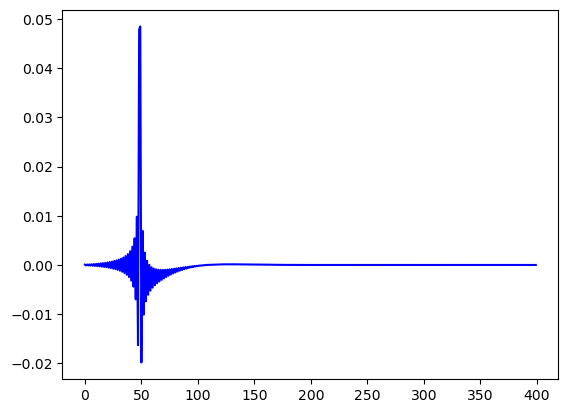

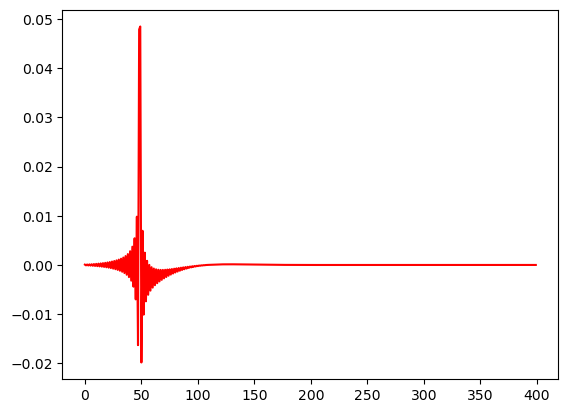

In [4]:
plt.plot(dp_rirs[0,0,:400],'b')
plt.figure()
plt.plot(dp_rirs_0[0,0,:400],'r')